# golub dataset

In [1]:
# install.packages("binom") # Installed from R studio as needs compilation
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("cancerclass")

In [2]:
library("ISLR") 
library("evaluomeR")
library("dplyr")
library("caret")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

# Table of contents
* [Dataset](#dataset)
    * [Removing correlated](#correlated)
    * [Top 200](#top)
    * [evaluomeR](#evaluomer)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
nci60 = as.data.frame(NCI60$data)

In [4]:
head(nci60)
print(paste0("Rows: ", nrow(nci60)))
print(paste0("Columns: ", ncol(nci60)))

,1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


[1] "Rows: 64"
[1] "Columns: 6830"


In [5]:
as.vector(unlist(as.data.frame(unique(NCI60$labs))))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

In [6]:
nci60["labels"] = rownames(nci60)
nci60 = nci60[ , c("labels", names(nci60)[names(nci60) != "labels"])]
nci60["labels"] = NCI60$labs
colnames(nci60)[colnames(nci60) == 'labels'] <- 'Description'
nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

In [7]:
unique(nci60$Description)
head(nci60)

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "OVARIAN"    
 [6] "MELANOMA"    "LEUKEMIA"    "K562B-repro" "K562A-repro" "COLON"      
[11] "MCF7A-repro" "MCF7D-repro"

,Description,1,2,3,4,5,6,7,8,9,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,CNS,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,CNS,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,CNS,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,RENAL,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,BREAST,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,CNS,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


# Removing correlated <a class="anchor" id="correlated"></a>
We address the issue of multicorrelation by identifying and removing highly correlated metrics (absolute correlation, 1) from our dataset+. First, we exclude the first column from the dataset `nci60`, where the column `Description` is. We then compute the correlation matrix R for data using the `cor` function. To pinpoint the metrics that exhibit perfect correlation (correlation coefficient of 1 or -1), we make use of the `findCorrelation` function from the `caret` package, setting a cutoff of 1. This function returns the names of the variables that are highly correlated, if any.

In [8]:
data = nci60[-1]
R = cor(data)
head(R)

1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
1.00000000,0.3833056,0.22006157,0.08724557,-0.08602104,0.08949880,0.1158955,0.37934513,0.15316722,0.18856013,...,0.00107821,-0.13456921,-0.12645356,-0.201420268,-0.21480468,-0.04013097,-0.034189686,-0.02287118,-0.09639277,-0.06072415
0.38330561,1.0000000,0.36433000,0.21617498,0.16558775,0.21444133,0.3699355,0.07807990,0.24695819,0.07245724,...,-0.02944743,-0.10859360,-0.04041393,0.003900317,0.02573318,-0.04360088,0.000302537,-0.06442559,-0.03610617,-0.05866152
0.22006157,0.3643300,1.00000000,0.23689049,0.12153801,0.03343932,0.1134791,0.01143216,-0.05276462,0.23168582,...,0.05290187,0.01976031,0.07319763,0.045394869,0.07732554,-0.12526880,-0.036734630,0.12118781,0.09385166,0.08099348
0.08724557,0.2161750,0.23689049,1.00000000,0.13438601,0.12715055,0.0590030,-0.06803698,-0.01874263,-0.12446127,...,-0.22308278,-0.28758473,-0.23071174,-0.259432992,-0.09173215,-0.17711090,0.001642882,-0.03740982,-0.03359966,-0.01586329
-0.08602104,0.1655877,0.12153801,0.13438601,1.00000000,0.26872823,0.2303654,-0.05813832,-0.04957305,-0.14754158,...,-0.17174975,-0.20977705,-0.14449000,-0.072001176,-0.13047178,0.10183611,0.073267124,-0.02843955,0.04111594,-0.06184830
0.08949880,0.2144413,0.03343932,0.12715055,0.26872823,1.00000000,0.4908452,0.19822509,0.22885592,0.05951340,...,-0.34521929,-0.26279137,-0.29911896,-0.143450848,-0.21673796,-0.21725913,-0.298911041,-0.22827261,-0.23197988,-0.20448364


In [9]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

Finally, we use `length(cor_metrics)` to determine the number of these highly correlated metrics. As this number is 0, we assess there are no highly correlated metrics.

# Top 200 <a class="anchor" id="top"></a>

In [10]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [11]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
4701,11.942075,4701
4700,11.429800,4700
256,7.978482,256
16,7.715338,16
4699,7.711871,4699
6393,7.659845,6393


In [12]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_row_list

[1] "4701" "4700" "256"  "16"   "4699" "6393" "6149" "286"  "6415" "4354"
 [11] "113"  "257"  "252"  "6391" "6150" "5942" "5557" "6151" "196"  "243" 
 [21] "4353" "6152" "5805" "5556" "5980" "5948" "6392" "5732" "3957" "5937"
 [31] "2068" "4344" "5869" "6416" "755"  "5868" "5586" "134"  "4094" "6279"
 [41] "112"  "5760" "6278" "5943" "4288" "5692" "6156" "4154" "6087" "2082"
 [51] "5804" "6688" "2074" "6635" "2080" "4244" "3518" "5705" "4308" "6277"
 [61] "1390" "5979" "4716" "2081" "224"  "5555" "1391" "975"  "754"  "3525"
 [71] "6412" "5838" "3936" "4093" "248"  "4425" "281"  "4060" "5803" "6084"
 [81] "4426" "133"  "2083" "6689" "301"  "6430" "5910" "5587" "6429" "5946"
 [91] "4280" "1389" "4057" "4085" "5917" "4289" "6710" "4388" "3248" "5796"
[101] "4306" "5275" "6612" "6274" "5845" "5706" "5472" "5828" "267"  "3543"
[111] "5940" "4304" "6717" "6646" "3438" "5870" "5884" "5707" "287"  "6128"
[121] "5984" "4327" "5353" "188"  "5972" "6153" "6148" "5142" "251"  "5758"
[131] "1393" "6157" "5988" "5496" "6264" "4383" "5867" "6413" "5481" "6356"
[141] "5829" "5729" "242"  "1388" "5510" "6644" "5588" "5981" "6419" "5276"
[151] "1120" "5477" "5417" "5691" "5712" "266"  "5836" "3956" "5830" "3706"
[161] "3894" "5730" "5646" "5973" "4010" "273"  "6404" "5843" "111"  "6243"
[171] "6086" "5913" "5561" "756"  "6154" "247"  "3490" "4387" "5661" "5916"
[181] "6272" "229"  "245"  "6564" "4845" "1012" "6414" "5899" "5631" "124" 
[191] "5721" "6622" "5336" "1067" "6288" "5872" "5489" "78"   "127"  "3383"

In [13]:
top_nci60 = nci60[, top_row_list]
#top_nci60["Description"] = rownames(top_nci60)
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 
head(top_nci60)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,...,5721,6622,5336,1067,6288,5872,5489,78,127,3383
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,...,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,...,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,...,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,...,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,...,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,...,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


# evaluomeR K analysis <a class="anchor" id="evaluomer"></a>

In [14]:
seed = 13606
k.range=c(3,10)
cbi = "rskc"

# Stab
stab_range = stabilityRange(data=top_nci60, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,L1=2,
                            cbi=cbi)
stab = standardizeStabilityData(stab_range)

# Qual
qual_range = qualityRange(data=top_nci60, k.range=k.range, 
                            seed=seed,
                            all_metrics=TRUE,L1=2,
                            cbi=cbi)
qual = standardizeQualityData(qual_range)

# K opt
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3


Step (a), (a2) and (b) are repeated over the maximum number of iterations. The algorithm might not converge.

	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7


Step (a), (a2) and (b) are repeated over the maximum number of iterations. The algorithm might not converge.

	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
Processing metric: all_metrics

	Both Ks do not have a stable classification: '5', '3'

	Using '3' since it provides higher silhouette width



[1] "Optimal k: 3"


In [15]:
print(paste0("W/ ", cbi))
stab
qual
print(paste0("Stab in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Qual in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "W/ rskc"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.5548206,0.4799349,0.6764004,0.6295348,0.6701263,0.6577755,0.6117243,0.64149


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.08996833,0.05054889,0.02500336,0.01236037,-0.01877709,-0.04426998,-0.01388859,-0.02037234


[1] "Stab in k=3: 0.554820555060489"
[1] "Qual in k=3: 0.089968328689503"


# Clusters

In [16]:
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [17]:
qual_cbi = qualityRange(data=top_nci60, k.range=k.range, 
                            seed=seed,
                            all_metrics=TRUE,L1=2,
                            cbi=cbi)
cluster_individuals = individuals_per_cluster(assay(qual_cbi[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
standardizeQualityData(qual_cbi)
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


[1] "CBI: rskc - k: 3"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.08996833,0.05054889,0.02500336,0.01236037,-0.01877709,-0.04426998,-0.01388859,-0.02037234


[1] "Cluster 1 : CNS,RENAL,BREAST,NSCLC,BREAST,BREAST,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA"
[1] "---"
[1] "Cluster 2 : BREAST,NSCLC,MELANOMA,OVARIAN,OVARIAN,OVARIAN,LEUKEMIA,K562B-repro,K562A-repro,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA,COLON,COLON,COLON,COLON,COLON,COLON,MCF7A-repro,BREAST,MCF7D-repro,BREAST,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 3 : CNS,CNS,CNS,CNS,BREAST,NSCLC,NSCLC,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,OVARIAN,OVARIAN,OVARIAN,NSCLC,NSCLC,COLON,NSCLC,MELANOMA"
[1] "---"


# PCA <a class="anchor" id="pca"></a>

In [18]:
#PCA
print(length(cluster_individuals$InCluster))
print(nrow(top_nci60))
top_nci60["inCluster"] = as.numeric(cluster_individuals$InCluster)
unique(cluster_individuals$InCluster)

[1] 61
[1] 61


[[1]]
[1] "3"

[[2]]
[1] "1"

[[3]]
[1] "2"

In [19]:
pca_matrix = top_nci60 %>% select(-Description, -inCluster)
head(pca_matrix)

,4701,4700,256,16,4699,6393,6149,286,6415,4354,...,5721,6622,5336,1067,6288,5872,5489,78,127,3383
V1,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,1.830000,...,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,0.999961,...,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,3.130000,...,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,3.850000,...,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,2.535000,...,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,0.240000,...,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


In [20]:
pca_result <- prcomp(pca_matrix, scale. = TRUE)

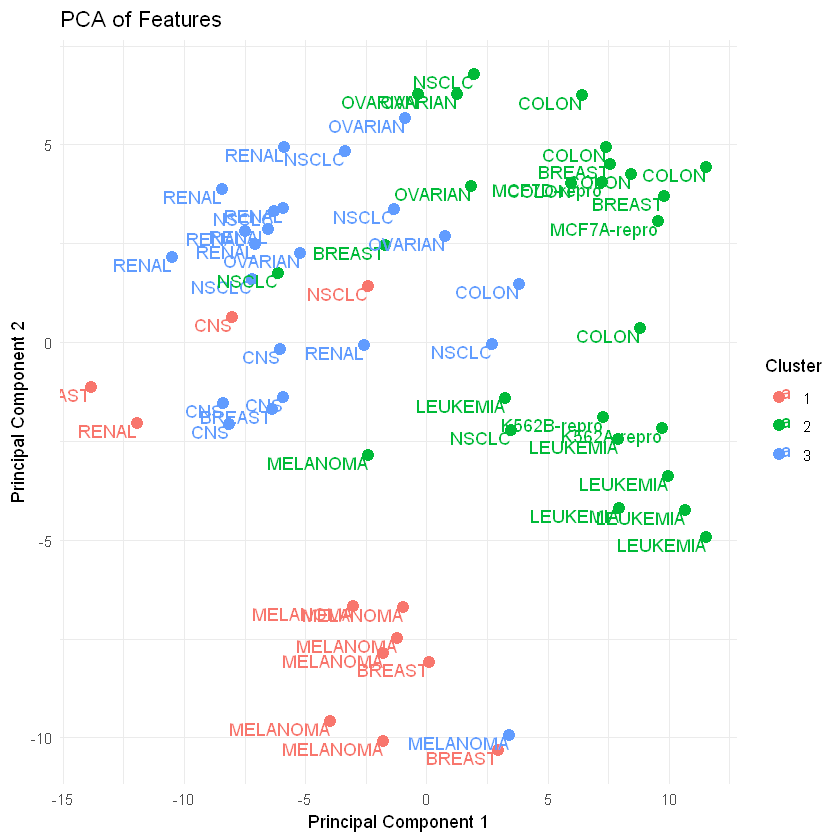

In [21]:
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_nci60$inCluster)
pca_df$Individual <- top_nci60$Description

# Plot PCA results

ggplot2::ggplot(pca_df, ggplot2::aes(x = PC1, y = PC2, color = Cluster, label = Individual)) +
  ggplot2::geom_point(size = 3) +
  ggplot2::geom_text(vjust = 1, hjust = 1) +
  ggplot2::labs(title = "PCA of Features",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  ggplot2::theme_minimal()

# Sensitivity <a class="anchor" id="sensitivity"></a>

In [22]:
library("MLmetrics")


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:RSKC':

    Sensitivity

The following object is masked from 'package:base':

    Recall



In [23]:
top_nci60["Class"] = top_nci60["Description"]
head(top_nci60)[, c("Description", "Class")]
#as.vector(unlist(unique(top_nci60["Class"])))

,Description,Class
V1,CNS,CNS
V2,CNS,CNS
V3,CNS,CNS
V4,RENAL,RENAL
V5,BREAST,BREAST
V6,CNS,CNS


In [24]:
# KMEANS
# k=8
# level_mapping <- c("NSCLC" = 1, "CNS" = 2, "BREAST" = 3,
#                  "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 4, 
#                  "LEUKEMIA" = 5, "K562B-repro" = 5, "K562A-repro" = 5, 
#                  "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8
#                   )
# k=9
# level_mapping <- c("NSCLC" = 8, "CNS" = 2, "BREAST" = 1,
#                   "MCF7A-repro" = 1, "MCF7D-repro" = 1, "RENAL" = 4,
#                   "LEUKEMIA" = 5, "K562B-repro" = 3, "K562A-repro" = 3, 
#                   "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8,
#                    "PROSTATE"= 9
#                    )
#k=10
# level_mapping <- c("NSCLC" = 10, "CNS" = 2, "BREAST" = 1,
#                   "MCF7A-repro" = 1, "MCF7D-repro" = 1, "RENAL" = 4, 
#                   "LEUKEMIA" = 3, "K562B-repro" = 5, "K562A-repro" = 5, 
#                   "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8,
#                    "PROSTATE"= 7, "UNKNOWN" = 9
#                    )


In [25]:
# CLARA
# k=6 (8 cat.)
level_mapping <- c("NSCLC" = 2, "CNS" = 1, "BREAST" = 5,
                 "MCF7A-repro" = 5, "MCF7D-repro" = 5, "RENAL" = 2, 
                 "LEUKEMIA" = 4, "K562B-repro" = 4, "K562A-repro" = 4, 
                 "MELANOMA" = 6,  "COLON" = 3, "OVARIAN" = 3
                  )
# k=8 (10 cat.)
# level_mapping <- c("NSCLC" = 2, "CNS" = 1, "BREAST" = 8,
#                   "MCF7A-repro" = 8, "MCF7D-repro" = 8, "RENAL" = 4, 
#                   "LEUKEMIA" = 7, "K562B-repro" = 6, "K562A-repro" = 6, 
#                   "MELANOMA" = 5,  "COLON" = 3, "OVARIAN" = 3,
#                    "PROSTATE"= 3, "UNKNOWN" = 4
#              )
map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}

In [26]:
top_nci60["Class_n"] = lapply(top_nci60["Class"], map_strings_to_numbers)
head(top_nci60)[, c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
V1,CNS,CNS,3,1
V2,CNS,CNS,3,1
V3,CNS,CNS,1,1
V4,RENAL,RENAL,1,2
V5,BREAST,BREAST,1,5
V6,CNS,CNS,3,1


In [27]:
#top_nci60[top_nci60$Description=="NSCLC", c("Description", "Class", "inCluster", "Class_n")]
top_nci60[, c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
V1,CNS,CNS,3,1
V2,CNS,CNS,3,1
V3,CNS,CNS,1,1
V4,RENAL,RENAL,1,2
V5,BREAST,BREAST,1,5
V6,CNS,CNS,3,1
V7,CNS,CNS,3,1
V8,BREAST,BREAST,3,5
V9,NSCLC,NSCLC,3,2
V10,NSCLC,NSCLC,3,2


In [28]:
# Getting a vector of clusters
actual = as.factor(as.vector(unlist(top_nci60["Class_n"])))
predicted <- factor(as.vector(unlist(top_nci60["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 1 1 1 2 5 1 1 5 2 2 2 2 2 2 2 2 2 5 2 2 3 6 3 3 3 3 3 2 2 2 4 4 4 4 4 4 4 4
[39] 3 3 3 3 3 3 3 5 5 5 5 2 2 2 6 5 5 6 6 6 6 6 6
Levels: 1 2 3 4 5 6

[1] "predicted"


[1] 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 2 2 2 2 3 3 3 3 1 2 2 2 2 2 2 2 2
[39] 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 1 1 1 1 1 1 1 1
Levels: 1 2 3

In [29]:
sens <- Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 20.00%"


# CER <a class="anchor" id="cer"></a>

In [30]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 33.06%"
